
# Advanced Topics

In [161]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import datetime
import pytz
import os
import glob
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa import stattools
from scipy.signal import savgol_filter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('notebook', font_scale=1.5,rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette("Paired"))

In [3]:
#Please change to the location of the git_hub reporsitory
os.chdir('/Users/nehrend/work/algo_trading_book/')

In [39]:
df = pd.read_csv('./datasets/S&P500.CSV',parse_dates=True,index_col='Date')
df = df.reset_index().groupby(pd.Grouper(key='Date',freq='W')).agg({'Close':'first','Volume':'sum'})
df.head()

,Close,Volume
Date,,
1990-01-07,359.690002,689930000.0
1990-01-14,353.790009,809580000.0
1990-01-21,337.000000,861310000.0
1990-01-28,330.380005,905970000.0
1990-02-04,325.200012,845440000.0


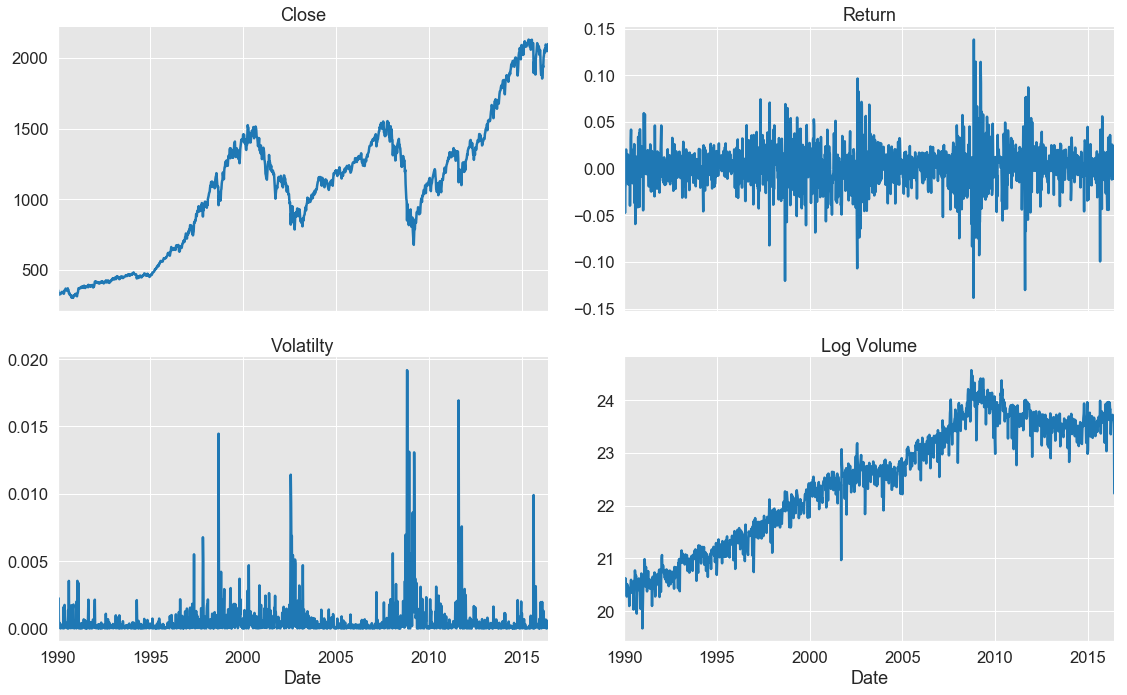

In [38]:
fig,ax = plt.subplots(2,2,figsize=(16,10),sharex=True)
_ = df.Close.plot(ax=ax[0,0],color='C1',title='Close')
_ = df.Close.pct_change(1).plot(ax=ax[0,1],color='C1',title='Return')
_ = df.Close.pct_change(1).pow(2).plot(ax=ax[1,0],color='C1',title='Volatilty')
_ = df.Volume.apply(lambda x: np.log(x)).plot(ax=ax[1,1],color='C1',title='Log Volume')
plt.tight_layout()
sns.despine()
plt.savefig('./book/chapters/chapter_advanced/figures/sp500.png', format='png', dpi=300)
plt.show()


In [124]:
d = pd.read_csv('./datasets/Figure5.2.CSV')
d.head()

,SYMBOL,DATE,TIME,PRICE,SIZE,COND,EX,Date1,Time1,averP,totVolume,N,d,f(i),lagd,d(i)
0,MSFT,20130102,4:31:47,26.99,156,T,P,20130102.0,4:31:47,26.99,156.0,1.0,NaN,-0.000003,NaN,0.000012
1,MSFT,20130102,4:50:17,26.99,100,@F,P,20130102.0,4:50:17,26.99,100.0,1.0,0.012847,-0.000006,NaN,0.000012
2,MSFT,20130102,4:53:00,26.99,1000,T,P,20130102.0,4:53:00,26.99,1000.0,1.0,0.001887,-0.000010,0.012847,0.000012
3,MSFT,20130102,4:57:39,26.99,744,T,P,20130102.0,4:57:39,26.99,744.0,1.0,0.003229,-0.000013,0.001887,0.000012
4,MSFT,20130102,6:36:06,27.23,100,@F,P,20130102.0,6:36:06,27.23,100.0,1.0,0.068368,-0.000016,0.003229,0.000012


log( 1-i/(n0+1)); d(i): ordered durations;

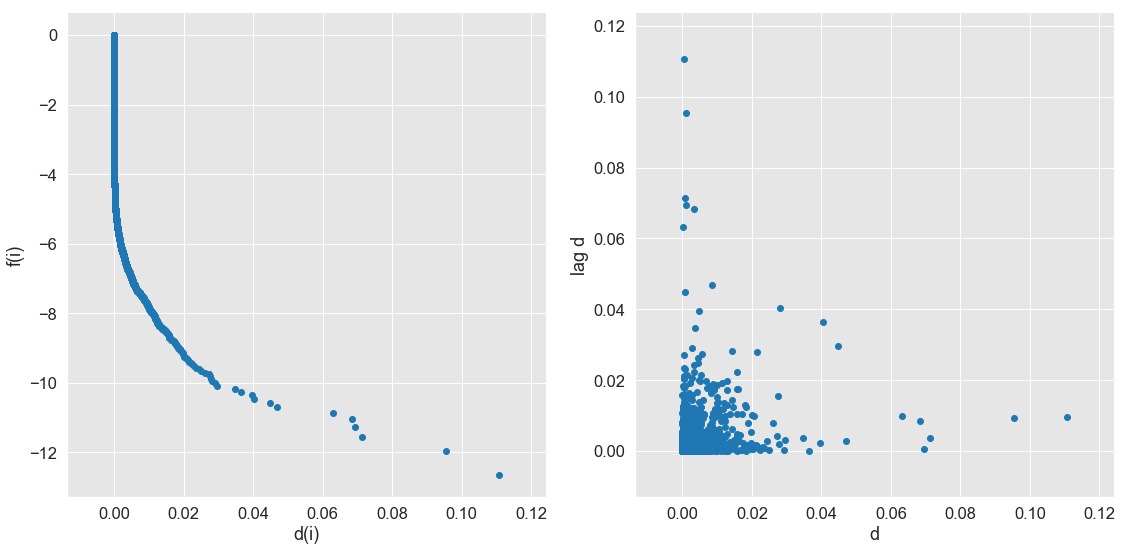

In [157]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
_ = ax[0].scatter(d['d(i)'],d['f(i)'],color='C1')
_ = ax[0].set_xlabel('d(i)')
_ = ax[0].set_ylabel('f(i)')

_ = ax[1].scatter(d['d'],d['d'].shift(-1),color='C1')
_ = ax[1].set_xlabel('d')
_ = ax[1].set_ylabel('lag d')
plt.tight_layout()
sns.despine()
plt.savefig('./book/chapters/chapter_advanced/figures/survivor.png', format='png', dpi=300)
plt.show()
   

In [165]:
d_times = d.d
d_times.shape
stats.describe(d_times.dropna())

DescribeResult(nobs=312486, minmax=(1.1574074074038874e-05, 0.1106134259259259), mean=3.885544442761406e-05, variance=2.969914912467605e-07, skewness=89.42496088576874, kurtosis=12630.129782895974)

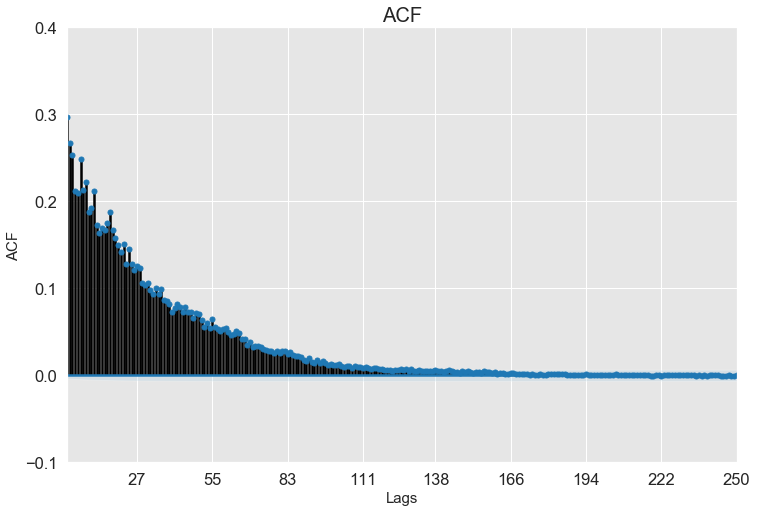

In [192]:
fig,ax = plt.subplots(figsize=(12,8))
_ = plot_acf(d_times.dropna(), lags=250, ax=ax, alpha=0.05,title=None,color='C1',)
_ = ax.set_xlabel('Lags',fontsize = 15)
_ = ax.set_ylabel('ACF',fontsize = 15)
_ = ax.set_ylim((-0.1,0.4))
_ = ax.set_xticks(np.linspace(0,250,10).astype(np.int32))
_ = ax.set_xlim((1,250))
plt.savefig('./book/chapters/chapter_advanced/figures/afc_duration.png',format='png',dpi=300)
_ = ax.set_title('ACF',fontsize = 20)
plt.show()

In [142]:
def aggregate_trades(df):
    d={}
    d['SIZE'] = df['PRICE'].sum()
    d['PRICE'] = np.sum(df['PRICE']*df['SIZE'])/df['SIZE'].sum()
    d['N'] = df.shape[0]
    return pd.Series(d,index=['SIZE','PRICE','N'])


In [133]:
df = d.loc[:,['SYMBOL','DATE','TIME','PRICE','SIZE']]
df.head()

,SYMBOL,DATE,TIME,PRICE,SIZE
0,MSFT,20130102,4:31:47,26.99,156
1,MSFT,20130102,4:50:17,26.99,100
2,MSFT,20130102,4:53:00,26.99,1000
3,MSFT,20130102,4:57:39,26.99,744
4,MSFT,20130102,6:36:06,27.23,100


In [134]:
df = df.assign(DATE=pd.to_datetime(df.DATE,format='%Y%m%d'),TIME=pd.to_timedelta(df.TIME,unit='h'))

In [143]:
df_agg = df.groupby(['SYMBOL','DATE','TIME']).apply(aggregate_trades)
df_agg.head()

KeyboardInterrupt: 

SIZE  PRICE
SYMBOL DATE       TIME                  
MSFT   2013-01-02 04:31:47  26.99  26.99
                  04:50:17  26.99  26.99
                  04:53:00  26.99  26.99
                  04:57:39  26.99  26.99
                  06:36:06  27.23  27.23

In [115]:
amzn = pd.read_pickle('./datasets/amzn_trades.gzip')
amzn =amzn.assign(Size=amzn.Size*100)
amzn = amzn.iloc[:1000]
amzn.shape
amzn.head()

,Size,Price
Timestamp,,
2016-10-03 09:30:00.011172,4000.0,835.11
2016-10-03 09:30:00.013316,6000.0,835.95
2016-10-03 09:30:00.013666,4000.0,835.11
2016-10-03 09:30:00.014006,900.0,835.95
2016-10-03 09:30:00.015107,3100.0,835.95


In [118]:
amzn_s = amzn.reset_index().groupby(pd.Grouper(key='Timestamp',freq='10ms')).apply(aggregate_trades).dropna()

In [78]:
def aggregate_trades(df):
    d={}
    d['Size'] = df['Size'].sum()
    d['Price'] = np.sum(df['Price']*df['Size'])/df['Size'].sum()
    return pd.Series(d,index=['Size','Price'])


In [82]:
amzn_agg.to_pickle('./datasets/amzn_trades.gzip')

In [120]:
amzn_s.head(2)

,Size,Price
Timestamp,,
2016-10-03 09:30:00.010,32900.0,835.768389
2016-10-03 09:30:00.080,30200.0,835.800000


In [105]:
amzn_s.shape

(2942, 2)